## Week 2-2 - Visualizing General Social Survey data

Your mission is to analyze a data set of social attitudes by turning it into vectors, then visualizing the result.

### 1. Choose a topic and get your data

We're going to be working with data from the General Social Survey, which asks Americans thousands of questions ever year, over decades. This is an enormous data set and there have been very many stories written from its data. The first thing you need to do is decide which questions and which years you are going to try to analyze.

Use their [data explorer](https://gssdataexplorer.norc.org/) to see what's available, and ultimately download an Excel file with the data. 

- Click the `Search Varibles` button.
- You will need at least a dozen or two related variables. Try selecting some using their `Filter by Module / Subject` interface.
- When you've made your selection, click the `+ All` button to add all listed variables, then choose `Extract Data` under the `Actions` menu.
- Then you have a multi-step process. Step 1 is just naming your extract
- Step 2: select variables *again!* Click `Add All` in the upper right of the "Variable Cart" in the "Choose Variables" step.
- Step 3: Skip it. You could use this to filter the data in various ways. 
- Step 4: Click `Select certain years` to pick one year of data, then check `Excel Workbook (data + metadata)` as the output format.
- Click `Create Extract` and wait a minute or two on the "Extracts" page until the spinner stops and turns into a download link.

You'll end up with an compressed file in tar.gz format, which you should be able to decompressed by double-clicking on it. Inside is an Excel file. Open it in Excel (or your favorite spreadsheet program) and resave it as a CSV.





In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math

In [2]:
# load your data set here
gss = pd.read_csv('Data.csv')
gss.head()

,Gss year for this respondent,"How often meet face to face with customers, clients, patients",How often meet face to face with co-workers to work on projects,How often exchange info with co-workers located outside usa,"Thinking about last full-time job, what yr r worked last",Why did r leave last job,Why job abolished or laid off,Why job abolished or laid off.1,Earnings from all sources for this job,In what country were you born,...,Why job abolished or laid off.3,How likely r will lose job or laid off in next 1 yr,Why that much possibility of job abolished or laid off,Why that much possibility of job abolished or laid off.1,Why that much possibility of job abolished or laid off.2,How likely r to find job with same/better benefit,"More trade, less jobs in usa",Jobs created are better than r's current job,Jobs taken away are better than r's current job,Ballot used for interview
0,2008,Not applicable,Not applicable,Not applicable,2005,Left voluntarily,Not applicable,Not applicable,"M. $20,000 to 22,499",Usa,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot b
1,2008,Several times per year,Daily,Daily,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Antigua,...,Not applicable,Not at all likely,Not applicable,Not applicable,Not applicable,Very easy,Created more jobs,Better,Not applicable,Ballot a
2,2008,Several times per week,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Usa,...,Not applicable,Very likely,Other,Job done,Not applicable,Somewhat easy,About the same,Not applicable,Not applicable,Ballot b
3,2008,Not applicable,Not applicable,Not applicable,2007,Permanently laid off,Other,Not applicable,"T. $60,000 to 74,999",Usa,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot c
4,2008,Daily,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Trinidad,...,Not applicable,Not at all likely,Not applicable,Not applicable,Not applicable,Somewhat easy,Created more jobs,About the same,Not applicable,Ballot a


### 3. Turn people  into vectors
I know, it sounds cruel. We're trying to group people, but computers can only group vectors, so there we are. 

Translating the spreadsheet you downloaded from GSS Explorer into vectors is a multistep process. Generally, each row of the spreadsheet is one person, and each column is one qeustion. 

- First, we need to throw away any extra rows and columns: headers, questions with no data, etc.
- Many GSS questions already have numerical answers. These usually don't require any work.
- But you'll need to turn categorical variables into numbers.

Basically, you have to remove or convert every value that isn't a number. Because this is survey data, we can turn most questions into an integer scale. The cleanup might use functions like this:

In [3]:
pd.set_option('max_colwidth',-1)
variables = pd.read_csv('Variables.csv')
variables.head()

,Name,Label,Description,Category
0,year,Gss year for this respondent,NaN,NaN
1,meetf2f1,"How often meet face to face with customers, clients, patients",NaN,NaN
2,meetf2f2,How often meet face to face with co-workers to work on projects,NaN,NaN
3,intlcowk,How often exchange info with co-workers located outside usa,NaN,NaN
4,lastyrwk,"Thinking about last full-time job, what yr r worked last",NaN,NaN


In [4]:
gss.columns = variables.Name
gss.head()

Name,year,meetf2f1,meetf2f2,intlcowk,lastyrwk,leavejb,whynojb1,whynojb2,inclstjb,bornsp,...,whyjbct2,losejb12,whylose1,whylose2,whylose3,findnwjb,moretrde,newjobs,lostjobs,ballot
0,2008,Not applicable,Not applicable,Not applicable,2005,Left voluntarily,Not applicable,Not applicable,"M. $20,000 to 22,499",Usa,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot b
1,2008,Several times per year,Daily,Daily,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Antigua,...,Not applicable,Not at all likely,Not applicable,Not applicable,Not applicable,Very easy,Created more jobs,Better,Not applicable,Ballot a
2,2008,Several times per week,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Usa,...,Not applicable,Very likely,Other,Job done,Not applicable,Somewhat easy,About the same,Not applicable,Not applicable,Ballot b
3,2008,Not applicable,Not applicable,Not applicable,2007,Permanently laid off,Other,Not applicable,"T. $60,000 to 74,999",Usa,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot c
4,2008,Daily,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Trinidad,...,Not applicable,Not at all likely,Not applicable,Not applicable,Not applicable,Somewhat easy,Created more jobs,About the same,Not applicable,Ballot a


In [5]:
# drop the last two rows, which are just notes and do not contain data
gss = gss.iloc[0:-2,:]
gss.tail()

Name,year,meetf2f1,meetf2f2,intlcowk,lastyrwk,leavejb,whynojb1,whynojb2,inclstjb,bornsp,...,whyjbct2,losejb12,whylose1,whylose2,whylose3,findnwjb,moretrde,newjobs,lostjobs,ballot
2018,2008,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot b
2019,2008,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot c
2020,2008,Daily,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Usa,...,Not applicable,Not too likely,Not applicable,Not applicable,Not applicable,Very easy,Not relevant for my job,Not applicable,Not applicable,Ballot b
2021,2008,Daily,Daily,Never,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Usa,...,Not applicable,Not at all likely,Not applicable,Not applicable,Not applicable,Not at all easy,About the same,Not applicable,Not applicable,Ballot b
2022,2008,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Usa,...,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Not applicable,Ballot c


In [6]:
codes = pd.read_csv('Codes.csv')
codes.head()

,Variable Position,Variable Name,Code,Label
0,1.0,meetf2f1,9,No answer
1,NaN,NaN,8,Dont know
2,NaN,NaN,6,Daily
3,NaN,NaN,5,Several times per week
4,NaN,NaN,4,Several times per month


In [7]:
for i in range(1,418):
    if codes.loc[i,'Code'] < codes.loc[i-1,'Code']:
        codes.loc[i,'Variable Position'] = codes.loc[i-1,'Variable Position']
        codes.loc[i,'Variable Name'] = codes.loc[i-1,'Variable Name']

In [8]:
codes.head()

,Variable Position,Variable Name,Code,Label
0,1.0,meetf2f1,9,No answer
1,1.0,meetf2f1,8,Dont know
2,1.0,meetf2f1,6,Daily
3,1.0,meetf2f1,5,Several times per week
4,1.0,meetf2f1,4,Several times per month


In [9]:
codes = codes[~codes.Label.isin(['Not applicable','No answer','Dont know'])]
codes = codes.reset_index().drop(columns='index')
codes['Variable Position'] = codes['Variable Position'].astype(int)
codes.head()

,Variable Position,Variable Name,Code,Label
0,1,meetf2f1,6,Daily
1,1,meetf2f1,5,Several times per week
2,1,meetf2f1,4,Several times per month
3,1,meetf2f1,3,Several times per year
4,1,meetf2f1,2,"Once per year or less, or"


In [10]:
len(codes)

315

Here's a bunch of cleanup code. It probably won't be quite right for your data.
The goal is to convert all values to small integers, to make them easy to plot with colors below.

In [11]:
# First, replace all of the "Not Applicable" values with None
gss = gss.replace({'Not applicable':None,
                   'No answer':None,
                   'Dont know':None})

In [12]:
for i in range(0,315):
    gss.replace({codes.Label[i]:codes.Code[i]},inplace=True)

In [13]:
gss.head()

Name,year,meetf2f1,meetf2f2,intlcowk,lastyrwk,leavejb,whynojb1,whynojb2,inclstjb,bornsp,...,whyjbct2,losejb12,whylose1,whylose2,whylose3,findnwjb,moretrde,newjobs,lostjobs,ballot
0,2008,NaN,NaN,NaN,2005,1.0,NaN,NaN,13.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,2008,3.0,6.0,6.0,None,NaN,NaN,NaN,NaN,2.0,...,NaN,4.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,1
2,2008,5.0,6.0,1.0,None,NaN,NaN,NaN,NaN,1.0,...,NaN,1.0,6.0,8.0,NaN,2.0,2.0,NaN,NaN,2
3,2008,NaN,NaN,NaN,2007,3.0,6.0,NaN,20.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
4,2008,6.0,6.0,1.0,None,NaN,NaN,NaN,NaN,3.0,...,NaN,4.0,NaN,NaN,NaN,2.0,1.0,2.0,NaN,1


In [14]:
# Drop some columns that don't contain useful information
gss = gss.drop(['ballot','year','lastyrwk','id_'], axis=1)

In [15]:
gss = gss.drop(['inclstjb','bornsp','natdeg','agecmeus','emphplan','othplan'],axis=1)

In [16]:
# Turn invalid numeric entries into zeros
gss = gss.replace({np.nan:0.0})

In [17]:
gss.head()

Name,meetf2f1,meetf2f2,intlcowk,leavejb,whynojb1,whynojb2,visa,typevisa,emphlth,autonojb,...,whyjbct1,whyjbct2,losejb12,whylose1,whylose2,whylose3,findnwjb,moretrde,newjobs,lostjobs
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,6.0,6.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
2,5.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,6.0,8.0,0.0,2.0,2.0,0.0,0.0
3,0.0,0.0,0.0,3.0,6.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6.0,6.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,...,0.0,0.0,4.0,0.0,0.0,0.0,2.0,1.0,2.0,0.0


In [18]:
gss.to_csv('gss_vec.csv')

### 4. Plot those vectors!
For this assignment, we'll use the PCA projection algorithm to make 2D (or 3D!) pictures of the set of vectors. Once you have the vectors, it should be easy to make a PCA plot using the steps we followed in class.
    

In [19]:
# make a PCA plot here
model = PCA(n_components=2)
out = model.fit_transform(gss)

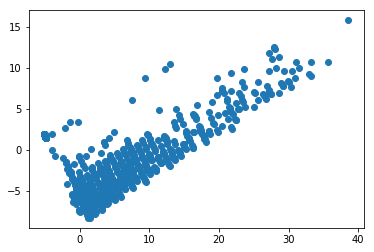

In [20]:
plt.scatter(out[:, 0], out[:, 1])
plt.show()

### 5. Add color to help interpretation
Congratulations, you have a picture of a blob of dots. Hopefully, that blob has some structure representing clusters of similar people. To understand what the plot is telling us, it really helps to take one of the original variables and use it to assign colors to the points. 

So: pick one of the questions that you think will separate people into natural groups. Use it to set the color of the dots in your scatterplot. By repeating this with different questions, or combining questions (like two binary questions giving rise to a four color scheme) you should be able to figure out what the structure of the clusters represents. 


In [21]:
# map integer columns to colors
def col2colors(colvals):
    # gray for zero, then a rainbow.
    # This is set up so yes = 1 = red and no = -1 = indigo
    my_colors = ['gray', 'red','orange','yellow','lightgreen','cyan','blue','indigo']
    
    # We may have integers higher than len(my_colors) or less than zero
    # So use the mod operator (%) to make values "wrap around" when they go off the end of the list
    column_ints = colvals.astype(int) % len(my_colors)
    
    # map each index to the corresponding color
    return column_ints.apply(lambda x: my_colors[x])

In [22]:
variables

,Name,Label,Description,Category
0,year,Gss year for this respondent,NaN,NaN
1,meetf2f1,"How often meet face to face with customers, clients, patients",NaN,NaN
2,meetf2f2,How often meet face to face with co-workers to work on projects,NaN,NaN
3,intlcowk,How often exchange info with co-workers located outside usa,NaN,NaN
4,lastyrwk,"Thinking about last full-time job, what yr r worked last",NaN,NaN
5,leavejb,Why did r leave last job,NaN,NaN
6,whynojb1,Why job abolished or laid off,NaN,NaN
7,whynojb2,Why job abolished or laid off,NaN,NaN
8,inclstjb,Earnings from all sources for this job,NaN,NaN
9,bornsp,In what country were you born,NaN,NaN


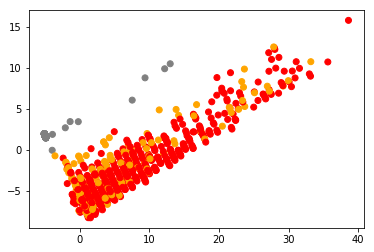

In [24]:
# Make a plot using colors from a particular column
plt.scatter(out[:, 0], out[:, 1], c=col2colors(gss.wkcomptr))
plt.show()

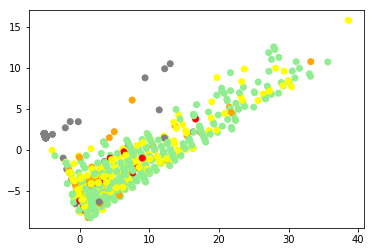

In [25]:
# Make another plot using colors from another column
plt.scatter(out[:, 0], out[:, 1], c=col2colors(gss.losejb12))
plt.show()

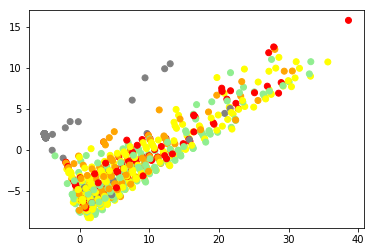

In [26]:
# ... repeat and see if you can figure out what each axis means
plt.scatter(out[:, 0], out[:, 1], c=col2colors(gss.moretrde))
plt.show()

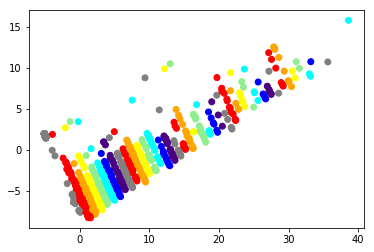

In [28]:
# ... repeat and see if you can figure out what each axis means
plt.scatter(out[:, 0], out[:, 1], c=col2colors(gss.curempyr))
plt.show()

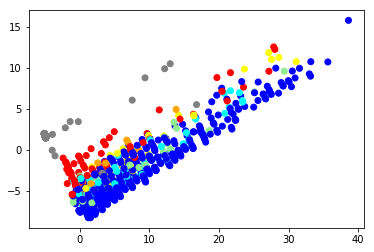

In [29]:
# ... repeat and see if you can figure out what each axis means
plt.scatter(out[:, 0], out[:, 1], c=col2colors(gss.meetf2f2))
plt.show()

### 6. Tell us what it means?
What did you learn from this exercise? Did you find the standard left-right divide? Or urban-rural? Early adopters vs. luddites? People with vs. without children? 

What did you learn? What could end up in a story? 


I chose the dataset for Global Economics. I'd like to figure out what type of people are working at global companies, but the result was not desirable. One of the reason is that the dataset doesn't contain categorical variables, only consists of questions about working situation.